In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [218]:
df = pd.read_csv('./../datasets/laptop_price.csv', encoding="ISO-8859-1")

df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [219]:
df.shape

(1303, 13)

In [220]:
df.drop('Product', axis=1, inplace=True)

In [221]:
companies = pd.get_dummies(df['Company'])
companies.columns = [f"Brand{b}" for b in companies.columns]

df = df.merge(companies, left_index=True, right_index=True)
df.drop('Company', axis=1, inplace=True)

In [222]:
types = pd.get_dummies(df.TypeName)
types.columns = [f"Type{t}" for t in types.columns]

df.merge(types, left_index=True, right_index=True)
df.drop('TypeName', axis=1, inplace=True)

In [223]:
df['isIPS'] = df.ScreenResolution.str.contains('ips', False).astype(int)

In [224]:
df['ScreenResolution'] = df.ScreenResolution.str.split(' ').map(lambda words: words[-1])

df.ScreenResolution.value_counts()

1920x1080    841
1366x768     308
3840x2160     43
3200x1800     27
2560x1440     23
1600x900      23
2560x1600      6
2304x1440      6
2256x1504      6
1920x1200      5
1440x900       4
2880x1800      4
2400x1600      4
2160x1440      2
2736x1824      1
Name: ScreenResolution, dtype: int64

In [225]:
df['ScreenHight'] = df.ScreenResolution.str.split('x').map(lambda wh: wh[1]).astype(int)
df['ScreenWidth'] = df.ScreenResolution.str.split('x').map(lambda wh: wh[0]).astype(int)

df.drop('ScreenResolution', axis=1, inplace=True)

In [226]:
df['CpuCompany'] = df.Cpu.str.split(' ').map(lambda x: x[0])
df['CpuFrequency'] = df.Cpu.str.split(' ').map(lambda x: x[-1])

df['CpuFrequency'] = df['CpuFrequency'].str.replace('GHz', '').astype(float)

df.drop('Cpu', axis=1, inplace=True)

In [227]:
df.Ram = df.Ram.str.replace('GB', '').astype(int)

df.drop('Ram', axis=1, inplace=True)

In [228]:
df['MemoryAmount'] = df.Memory.str.split(' ').map(lambda x: x[0])
df['MemoryType'] = df.Memory.str.split(' ').map(lambda x: x[1])

def convertor(amount: str):
    if 'GB' in amount:
        amount = amount.replace('GB', '')
    if 'TB' in amount:
        amount = float(amount.replace('TB', ''))
        amount *= 1024
    
    return float(amount)

df['MemoryAmount'] = df.MemoryAmount.map(convertor)

df.drop('Memory', axis=1, inplace=True)


In [229]:
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)

In [230]:
df['GpuCompany'] = df.Gpu.str.split(' ').map(lambda x: x[0])

df.drop('Gpu', axis=1, inplace=True)

In [231]:
os_sys = pd.get_dummies(df.OpSys)

df = df.merge(os_sys, left_index=True, right_index=True)

df.drop('OpSys', axis=1, inplace=True)

In [232]:
cpu_categories = pd.get_dummies(df.CpuCompany)

cpu_categories.columns = [ f"Cpu{c}" for c in cpu_categories.columns]

df = df.merge(cpu_categories, left_index=True, right_index=True)

gpu_categories = pd.get_dummies(df['GpuCompany'])
gpu_categories.columns = [f"Gpu{c}" for c in gpu_categories.columns]

df = df.merge(gpu_categories, left_index=True, right_index=True)

In [233]:
df.drop(columns=['GpuCompany', 'CpuCompany'], inplace=True)

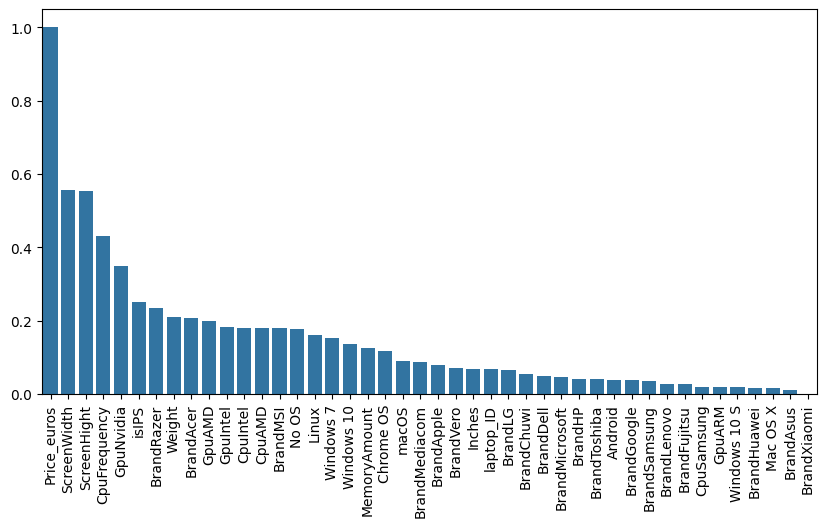

In [234]:
corr = df.corrwith(df['Price_euros']).abs().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(corr)
plt.xticks(rotation=90)
plt.show()

In [235]:
target_columns = corr.iloc[:21]

target_columns = target_columns.index.tolist()
target_columns

['Price_euros',
 'ScreenWidth',
 'ScreenHight',
 'CpuFrequency',
 'GpuNvidia',
 'isIPS',
 'BrandRazer',
 'Weight',
 'BrandAcer',
 'GpuAMD',
 'GpuIntel',
 'CpuIntel',
 'CpuAMD',
 'BrandMSI',
 'No OS',
 'Linux',
 'Windows 7',
 'Windows 10',
 'MemoryAmount',
 'Chrome OS',
 'macOS']

In [236]:
selected_data = df[target_columns]

In [238]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

scaler = StandardScaler()

X, y = selected_data.drop('Price_euros', axis=1), selected_data['Price_euros']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [242]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [243]:
forest = RandomForestRegressor()

forest.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [244]:
forest.score(X_test_scaled, y_test)

0.7726923790010839

In [245]:
y_predicted = forest.predict(X_test_scaled)

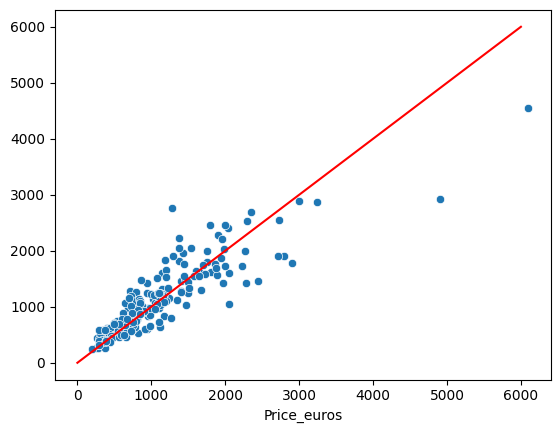

In [248]:
sns.scatterplot(x=y_test, y=y_predicted)
sns.lineplot(x=np.arange(1, 6000), y=np.arange(1, 6000), color='red')

plt.show()